In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Methodology

### Define the drought identification method

In [33]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

### Verification data 

In [34]:
# Read CSV file containing Capacity Factor from EirGrid wind
cf_wind = pd.read_csv('../Data/verification_cf_wind_1423.csv',
                         index_col=0,
                         usecols = [0,1,2,5,3])

# Set the index to timestamps
cf_wind.index = pd.to_datetime(cf_wind.index)
cf_wind = cf_wind.sort_index()
cf_wind.columns = 'onshorewind_eirgrid', 'onshorewind_atlite', 'onshorewind_c3se_national', 'onshorewind_c3se_gridded'

cf_wind_avg = cf_wind.rolling('D', min_periods=24, center=True).mean()

Detect Droughts for wind and PV

In [36]:
droughts_dict = {}

for column_wind in cf_wind_avg:
    # Identify events below TH
    raw_droughts_wind = identify_drought(cf_wind_avg[column_wind], 0.1)
    #Select only events longer than 24 hours
    droughts_wind = raw_droughts_wind[raw_droughts_wind > 24]
    # Set results in data frames
    droughts_df_wind = pd.DataFrame(droughts_wind)
    droughts_df_wind = droughts_df_wind.set_axis(['Duration'], axis=1)
    # Srt results in dict
    droughts_dict[column_wind] = droughts_df_wind

In [37]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "axes.labelsize": 12,               # Font size for labels
    "font.size": 12,                    # General font size
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

## Plots

In [38]:
bar_width = 0.2
xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']

# Define duration ranges in hours
duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192 ,np.inf]

# Convert duration ranges to days
duration_ranges_days = [dur / 24 for dur in duration_ranges_hours]

# Group datasets based on categories
categories = {
    'wind': ['onshorewind_eirgrid', 'onshorewind_atlite', 'onshorewind_c3se_gridded', 'onshorewind_c3se_national']
}

label_name = ['EirGrid', 'Atlite', 'C3S-E Gridded', 'C3S-E National']
color_models = ['black', '#B03024', '#348ABD', '#988ED5']

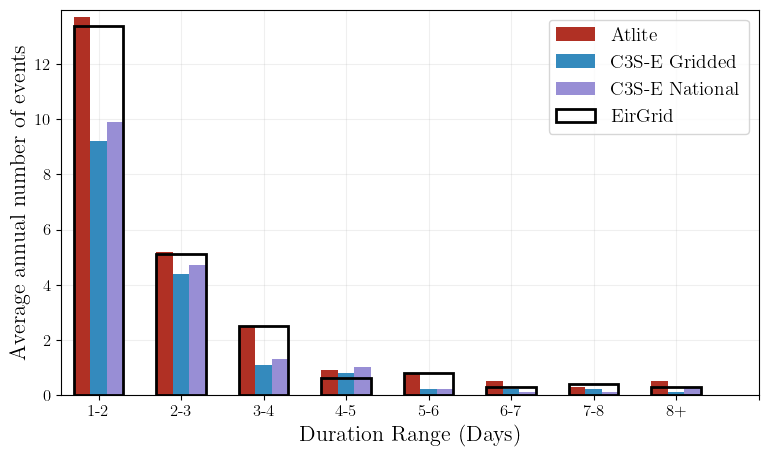

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharey=True)

# Initialize the position for bars
positions_wind = np.arange(len(duration_ranges_days) - 1)  # Ensure correct length

# Variable to store the EirGrid bar heights
eirgrid_heights = None

# Loop over categories for wind
for i, name in enumerate(categories['wind']):
    df = droughts_dict[name]
    # Calculate number of events for each duration range
    df['DurationRange'] = pd.cut(df['Duration'], bins=duration_ranges_hours)
    df['Year'] = df.index.year
    annual_counts = df.groupby(['Year', 'DurationRange'], observed=True).size().unstack(fill_value=0)

    # Calculate mean and std for each duration range across all years
    mean_counts = annual_counts.mean()
    std_counts = annual_counts.std()

    # Extract midpoints of duration ranges for plotting
    duration_midpoints = [((dur.left + dur.right) / 2) / 24 for dur in mean_counts.index]  # Convert back to days

    if i == 0:  # EirGrid, store heights for later use
        eirgrid_heights = mean_counts.values
    else:  # Plot other datasets with alpha=0.8
        ax.bar(
            positions_wind + (i - 1) * bar_width - 0.2,
            mean_counts,
            width=bar_width,
            color=color_models[i],
            label=label_name[i],
            zorder=2,  # Models in the background
        )

# Add an outline bar plot for EirGrid
if eirgrid_heights is not None:
    ax.bar(
        positions_wind,  # Centered around the first bar
        eirgrid_heights,
        width=bar_width * 3,  # Adjust width to encompass all models
        facecolor='none',  # No fill
        edgecolor='black',  # Black outline
        linewidth = 2,  # Line thickness for visibility
        label='EirGrid',  # Label for the legend
        zorder=3,  # Bring to the foreground
    )

ax.legend(loc='upper right', fontsize=14)
ax.margins(0.02)
ax.grid(True, alpha=0.2, zorder=0)

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(duration_ranges_days)))
ax.set_xticklabels(xlabel)
ax.tick_params(labelsize=12)

ax.set_ylabel('Average annual number of events', fontsize=16)
ax.set_xlabel('Duration Range (Days)', fontsize=16)
fig.savefig('../Figures/verification_wind_bar.png')